#Efficient SAM Example

This script provides example for how to get visualization result from EfficientSAM using weight file, part of the code is borrow from MobileSAM project, many thanks!

##Setup

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.transforms import ToTensor
from PIL import Image
import io

#Box and Point prompt

In [20]:
def run_ours_box_or_points(img_path, pts_sampled, pts_labels, model):
    image_np = np.array(Image.open(img_path))
    img_tensor = ToTensor()(image_np)
    pts_sampled = torch.reshape(torch.tensor(pts_sampled), [1, 1, -1, 2])
    pts_labels = torch.reshape(torch.tensor(pts_labels), [1, 1, -1])
    predicted_logits, predicted_iou = model(
        img_tensor[None, ...],
        pts_sampled,
        pts_labels,
    )

    sorted_ids = torch.argsort(predicted_iou, dim=-1, descending=True)
    predicted_iou = torch.take_along_dim(predicted_iou, sorted_ids, dim=2)
    predicted_logits = torch.take_along_dim(
        predicted_logits, sorted_ids[..., None, None], dim=2
    )

    return torch.ge(predicted_logits[0, 0, 0, :, :], 0).cpu().detach().numpy()

#Visualization Related

In [21]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.8])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="yellow", facecolor=(0, 0, 0, 0), lw=5)
    )


def show_anns_ours(mask, ax):
    ax.set_autoscale_on(False)
    img = np.ones((mask.shape[0], mask.shape[1], 4))
    img[:, :, 3] = 0
    # for ann in mask:
    #     m = ann
    color_mask = np.concatenate([np.random.random(3), [0.5]])
    img[mask] = color_mask
    ax.imshow(img)


#Create the model and load the weights from the checkpoint.

In [22]:
!git clone https://github.com/yformer/EfficientSAM.git
import os
os.chdir("EfficientSAM")

Cloning into 'EfficientSAM'...
remote: Enumerating objects: 264, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 264 (delta 47), reused 29 (delta 21), pack-reused 180
Receiving objects: 100% (264/264), 181.10 MiB | 19.59 MiB/s, done.
Resolving deltas: 100% (142/142), done.


In [23]:
from efficient_sam import build_efficient_sam_vitt, build_efficient_sam_vits

efficient_sam = build_efficient_sam_vitt()
efficient_sam.eval()


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (proj): Linear(in_features=192, out_features=192, bias=True)
        )
        (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=768, out_features=192, bias=True)
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(192, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )
  )
  (pro

## Box segmentation

prepare your own image here

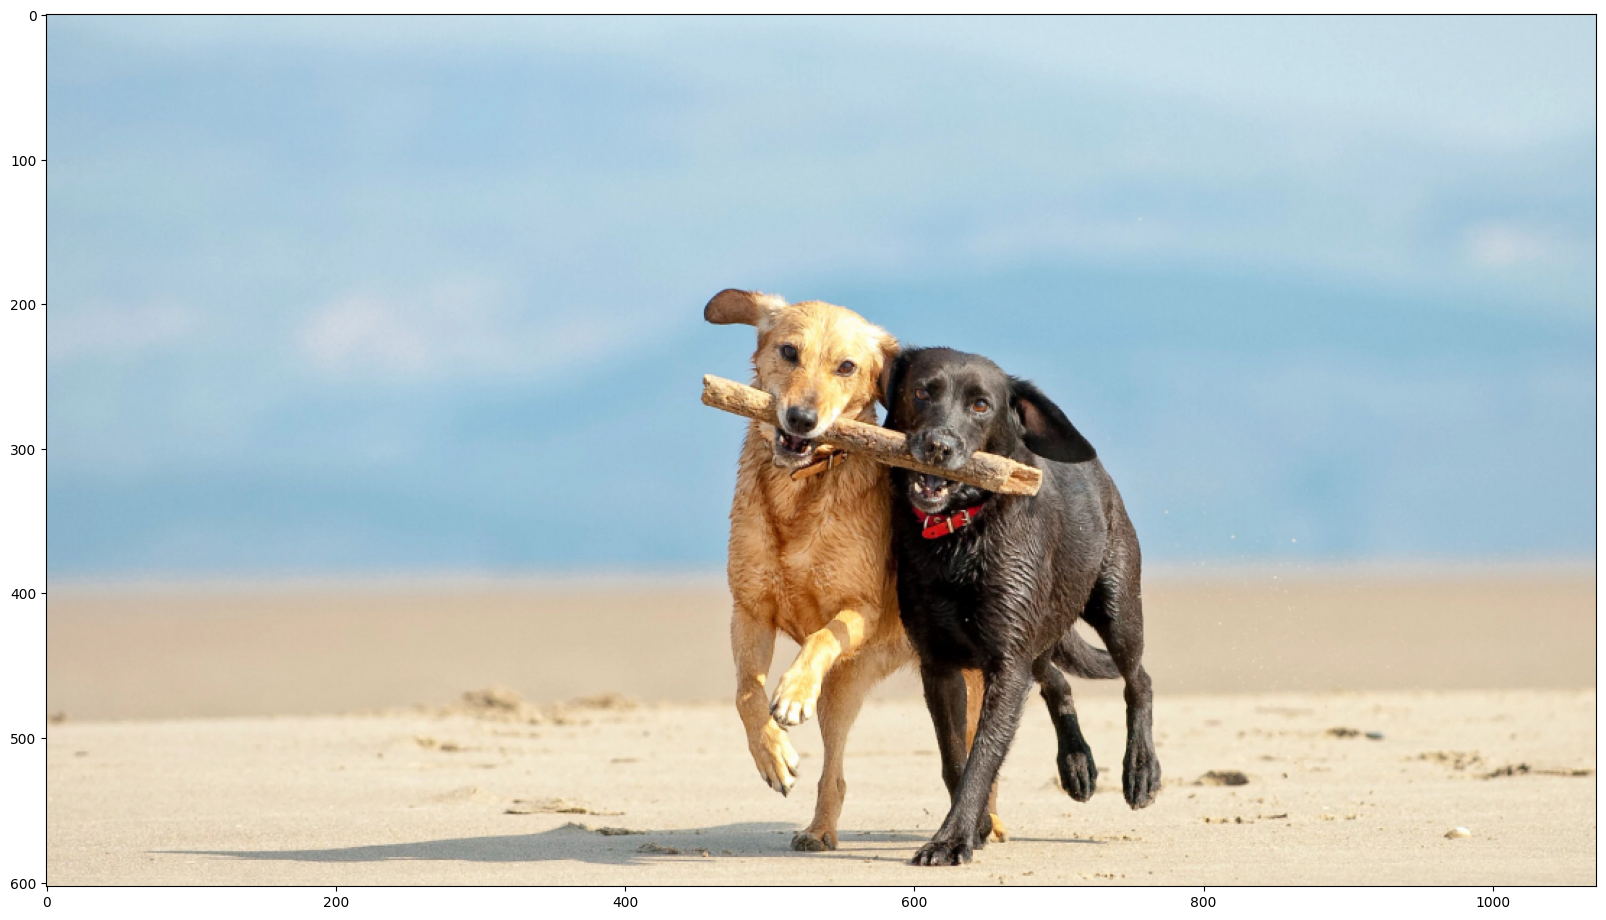

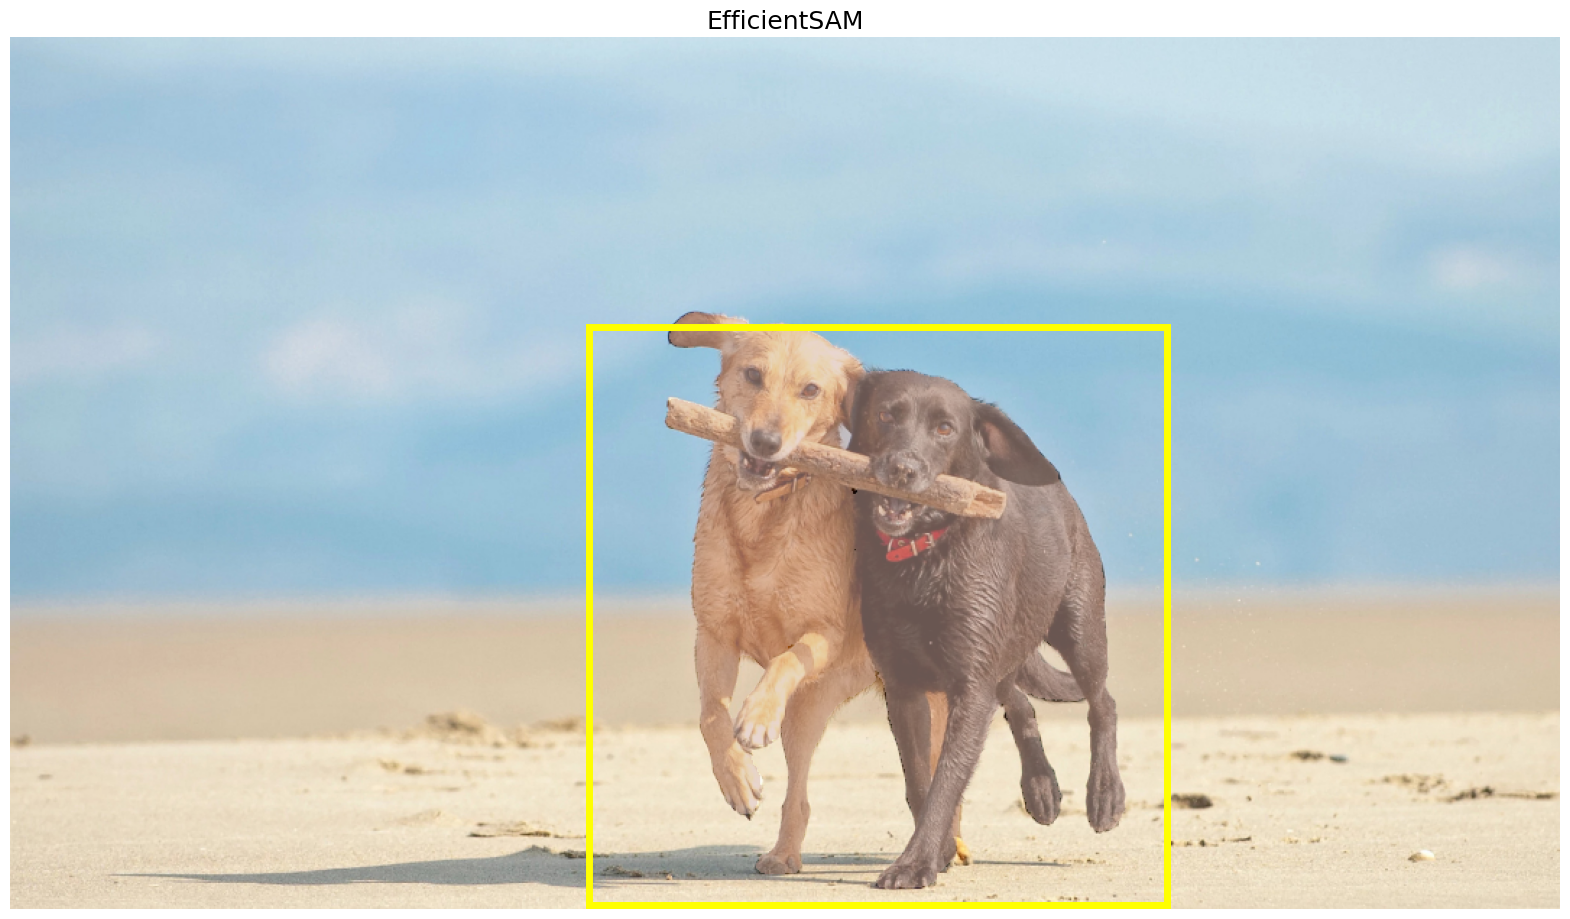

In [25]:
x1=400
y1=200
x2=800
y2=600
w=x2-x1
h=y2-y1
input_point = np.array([[x1, y1], [x2, y2]])
input_label = np.array([2,3])
image_path = "figs/examples/dogs.jpg"

mask_ours = run_ours_box_or_points(image_path, input_point, input_label, efficient_sam)
image = np.array(Image.open(image_path))
plt.figure(figsize=(20,20))
plt.imshow(image)

plt.figure(figsize=(20,20))
show_box([x1,y1,x2,y2], plt.gca())
plt.imshow(image)
show_anns_ours(mask_ours, plt.gca())
plt.title(f"EfficientSAM", fontsize=18)
plt.axis('off')
plt.show()

## Point segmentation

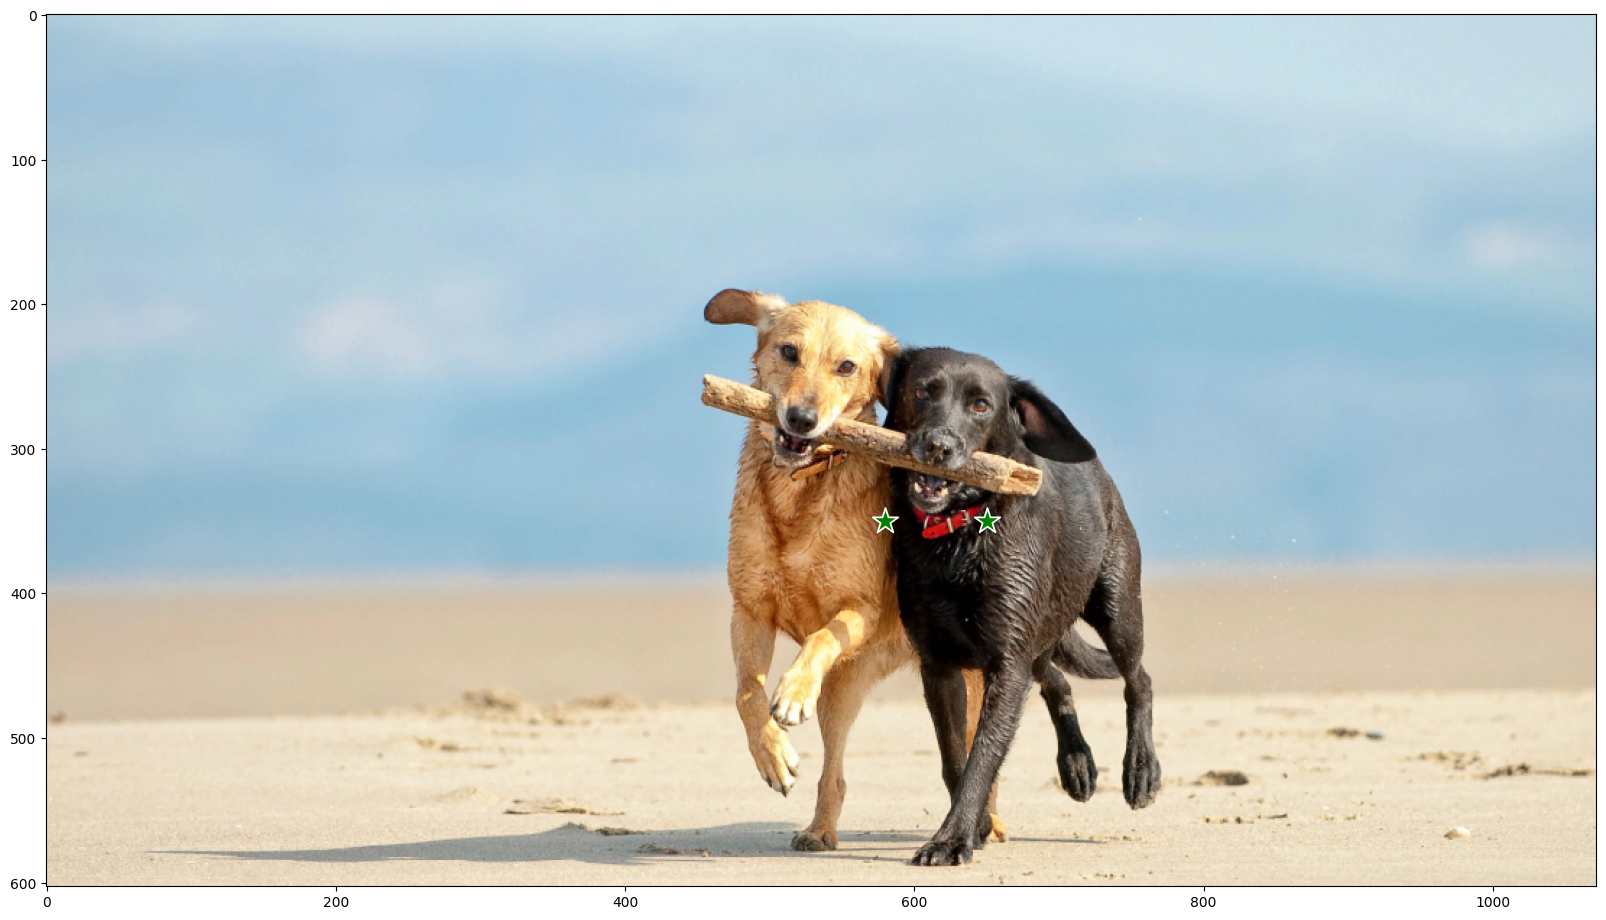

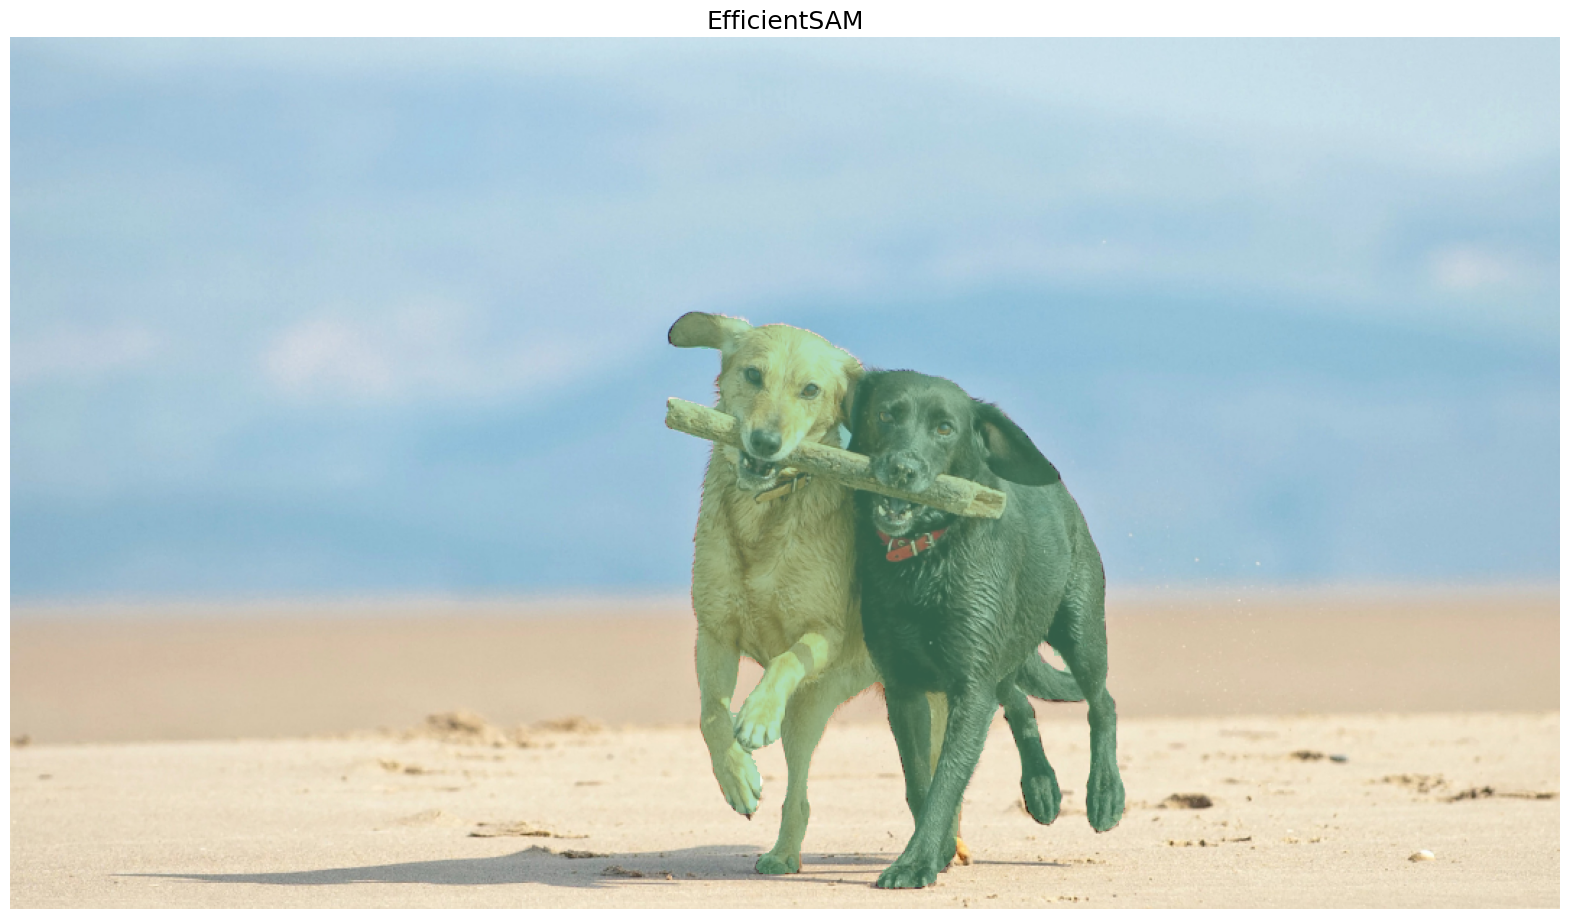

In [26]:
input_point = np.array([[580, 350], [650, 350]])
input_label = np.array([1, 1])
image_path = "figs/examples/dogs.jpg"
mask_ours = run_ours_box_or_points(image_path, input_point, input_label, efficient_sam)
image = np.array(Image.open(image_path))
plt.figure(figsize=(20, 20))
show_points(input_point, input_label, plt.gca())
plt.imshow(image)

plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns_ours(mask_ours, plt.gca())
plt.title(f"EfficientSAM", fontsize=18)
plt.axis("off")
plt.show()